# Figure S5. Effect of age on E-I ratio across the conjunction mask of significant age effects across datasets

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Get conjunction mask:

In [3]:
stats_age_pnc = pd.read_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv", index_col=0)
stats_age_imagen = pd.read_csv("p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv", index_col=0)
conj = (stats_age_pnc["p_fdr"] < 0.05) & (stats_age_imagen["p_fdr"] < 0.05)

Load IMAGEN data and calculate age effect:

In [4]:
try:
    data = pd.read_csv("imagen_fc-ses_sc-FU2_runs-2_data.csv", index_col=[0,1])
except FileNotFoundError:
    print("Run Figure 3 first")

try:
    I_E = pd.read_csv("imagen_fc-ses_sc-FU2_runs-2_IE.csv", index_col=[0,1])
except FileNotFoundError:
    print("Run Figure 3 first")

In [5]:
df_imagen = pd.concat([I_E, data], axis=1)
# calculate average
df_imagen["conj_I_E"] = df_imagen.loc[:, conj[conj].index].mean(axis=1)
# exclude outliers
curr_subs_BL = (
    df_imagen.loc[(slice(None), ["BL"]), "conj_I_E"]
    .loc[
        ~(
            scipy.stats.zscore(df_imagen.loc[(slice(None), ["BL"]), "conj_I_E"]).abs()
            >= 3
        )
    ]
    .index.get_level_values(0)
)
curr_subs_FU2 = (
    df_imagen.loc[(slice(None), ["FU2"]), "conj_I_E"]
    .loc[
        ~(
            scipy.stats.zscore(df_imagen.loc[(slice(None), ["FU2"]), "conj_I_E"]).abs()
            >= 3
        )
    ]
    .index.get_level_values(0)
)
curr_subs = curr_subs_BL.intersection(curr_subs_FU2)
model_df = df_imagen.loc[(curr_subs, slice(None))].reset_index(drop=False)
# calculate standardized mean difference of I_E resid as a variant of Cohen's d
res_conf = smf.mixedlm(
    "conj_I_E ~ gof + sex + mean_rms + site", data=model_df, groups=model_df["sub"]
).fit()
model_df["resid"] = res_conf.resid
resid_diff = (
    model_df.loc[model_df["ses"] == "FU2", "resid"].values
    - model_df.loc[model_df["ses"] == "BL", "resid"].values
)
d_age_conj = resid_diff.mean() / resid_diff.std(ddof=1)
# fit the main model
mod = smf.mixedlm(
    "conj_I_E ~ age + gof + sex + mean_rms + site",
    data=model_df,
    groups=model_df["sub"],
)
res = mod.fit()
print("Cohen's d:", d_age_conj)
print(res.summary())

Cohen's d: -0.31237004504668586
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  conj_I_E 
No. Observations:    296      Method:              REML     
No. Groups:          148      Scale:               0.0000   
Min. group size:     2        Log-Likelihood:      1523.8140
Max. group size:     2        Converged:           Yes      
Mean group size:     2.0                                    
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.381    0.001 656.482 0.000  0.380  0.382
sex[T.M]         -0.000    0.000  -1.742 0.082 -0.001  0.000
site[T.Dublin]    0.000    0.001   0.103 0.918 -0.001  0.001
site[T.London]   -0.001    0.000  -2.346 0.019 -0.001 -0.000
site[T.Mannheim] -0.000    0.000  -1.864 0.062 -0.001  0.000
site[T.Paris]    -0.000    0.000  -2.217 0.027 -0.001 -0.000
age 

In [6]:
# for plotting
model_df_imagen = model_df
res_imagen = res

Load PNC data and calculate age effect:

In [7]:
try:
    data_pnc = pd.read_csv("pnc_data.csv", index_col=0)
except FileNotFoundError as e:
    print("Run Figure 2 first")
    raise(e)
try:
    I_E_pnc = pd.read_csv("pnc_IE.csv", index_col=0)
except FileNotFoundError as e:
    print("Run Figure 2 first")
    raise(e)

df_pnc = pd.concat([I_E_pnc, data_pnc], axis=1)

In [8]:
# calculate average
df_pnc["conj_I_E"] = df_pnc.loc[:, conj[conj].index].mean(axis=1)
# exclude outliers
curr_subs = df_pnc.index[(scipy.stats.zscore(df_pnc.loc[:, "conj_I_E"]).abs() < 3)]
model_df = df_pnc.loc[curr_subs]
# fit the confound removal model to calculate pearson's r of the
# residual of I_E with age as an easy-to-interpret effect size
res_conf = smf.ols("conj_I_E ~ gof + sex + mean_rms", data=model_df).fit()
model_df["resid"] = res_conf.resid
r_age = scipy.stats.pearsonr(model_df["age"], model_df["resid"]).statistic
# fit the main model
mod = smf.ols("conj_I_E ~ age + gof + sex + mean_rms", data=model_df)
res = mod.fit()
print("Pearson's r", r_age)
print(res.summary())

Pearson's r -0.23222033701651776
                            OLS Regression Results                            
Dep. Variable:               conj_I_E   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     20.70
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           3.45e-16
Time:                        11:20:22   Log-Likelihood:                 3898.6
No. Observations:                 746   AIC:                            -7787.
Df Residuals:                     741   BIC:                            -7764.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.37

In [9]:
# for plotting
model_df_pnc = model_df
res_pnc = res

Plot:

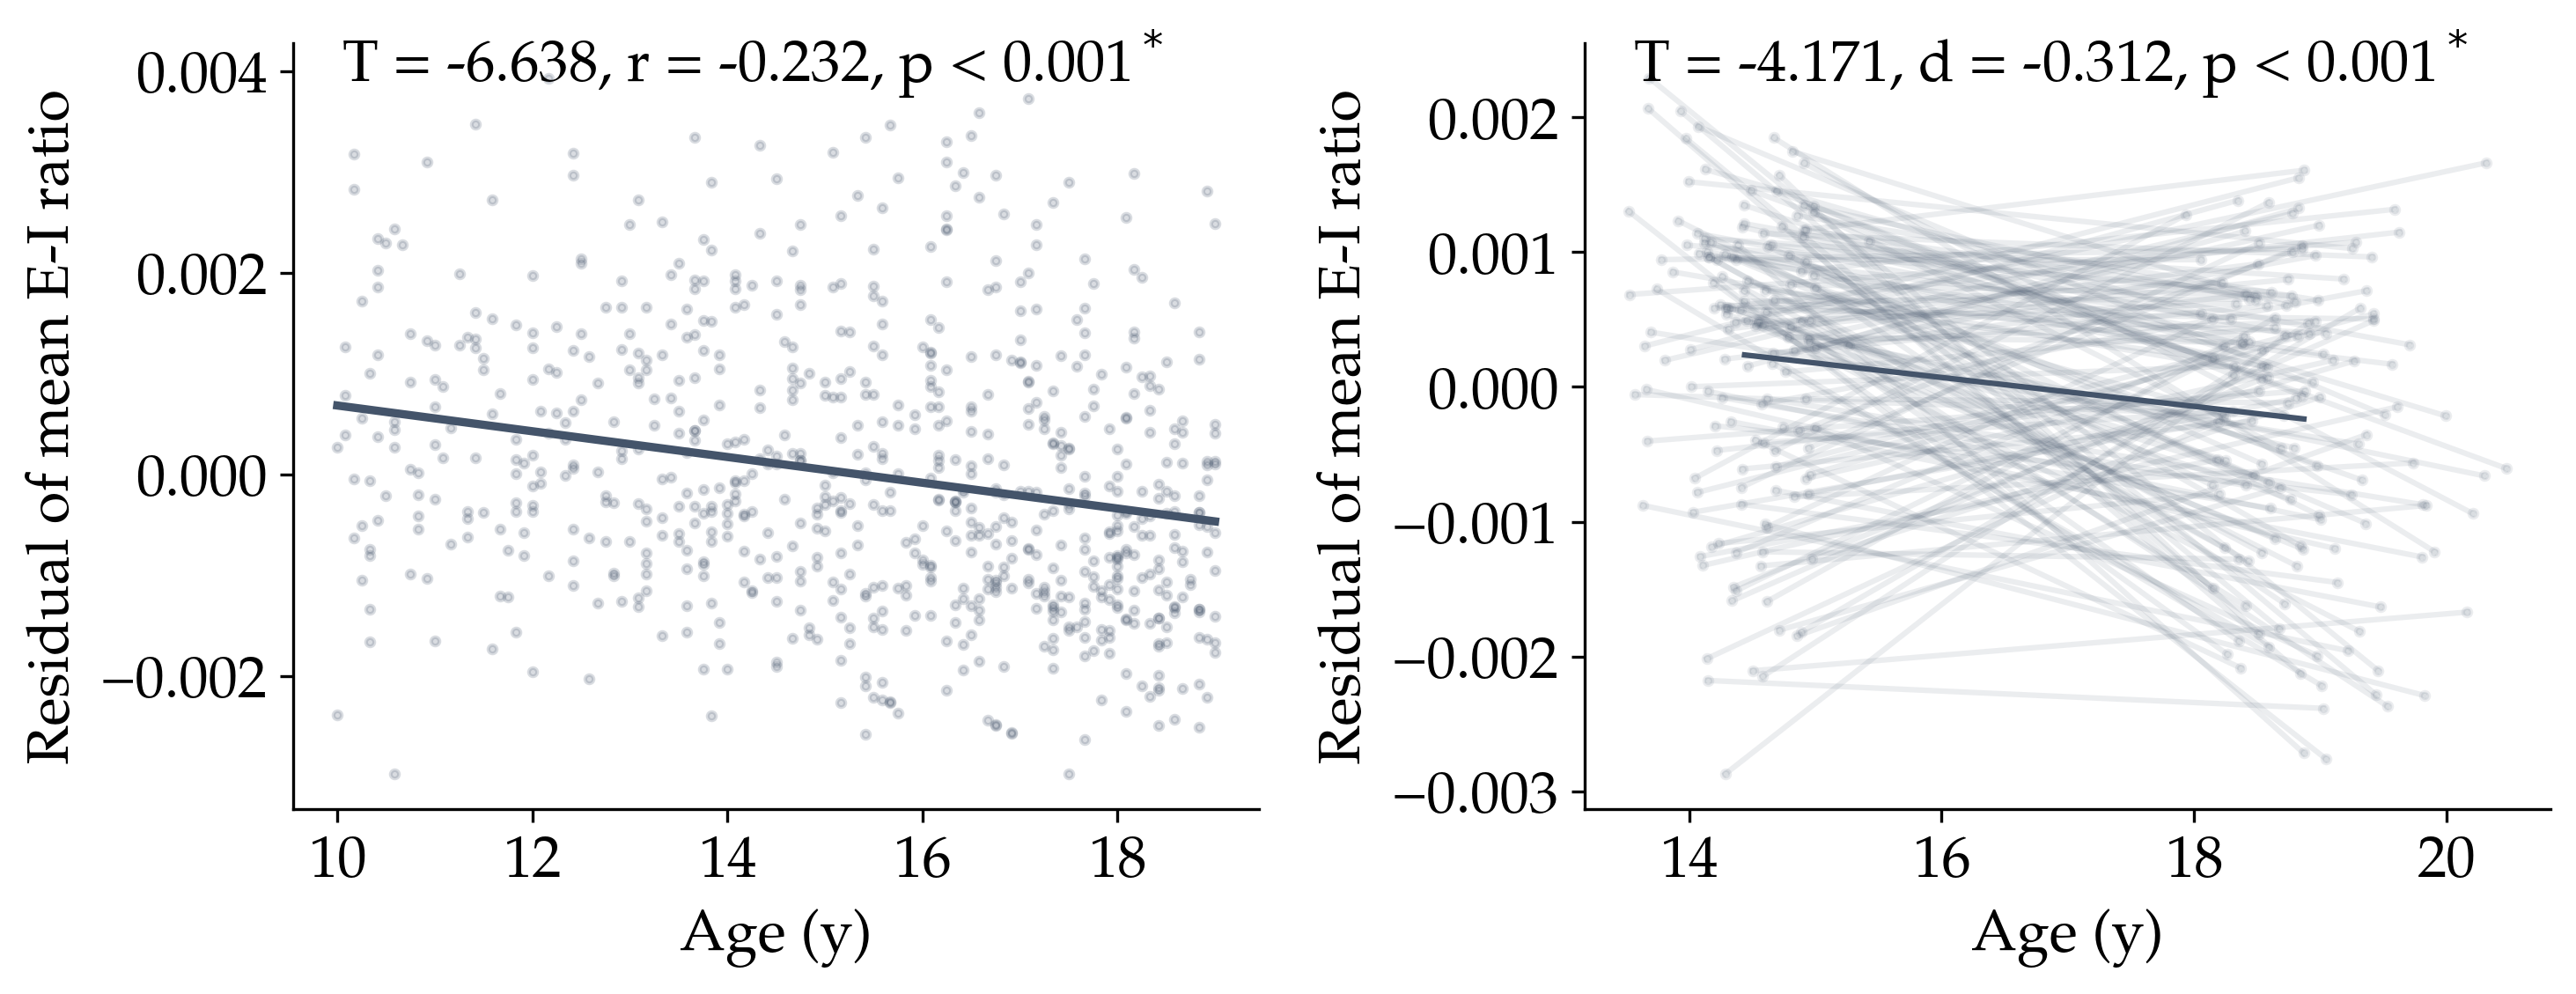

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
add_text = True

# pnc
ax = axes[0]
sns.regplot(
    x=model_df_pnc["Age (y)"],
    y=model_df_pnc["resid"],
    ax=ax,
    ci=None,
    scatter_kws=dict(color=thcolor, alpha=0.2, s=5),
    line_kws=dict(color=thcolor, alpha=1.0),
)
p = res_pnc.pvalues["age"]
t = res_pnc.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, r = {r_age:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += ", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=16, multialignment="left")
ax.set_ylabel(r"Residual of mean E-I ratio")
ax.set_xlabel("Age (y)")
sns.despine()

# imagen
ax = axes[1]
ax.scatter(
    model_df_imagen["age"], model_df_imagen["resid"], color=thcolor, s=5, alpha=0.1
)
# plot lines for each subject
for sub in model_df_imagen["sub"].unique():
    sub_df = model_df_imagen.loc[model_df_imagen["sub"] == sub]
    ax.plot(
        sub_df["age"],
        sub_df["resid"],
        color=thcolor,
        alpha=0.1,
    )
# plot the mean line of all subjects
ax.plot(
    model_df_imagen.groupby("ses")["age"].mean(),
    model_df_imagen.groupby("ses")["resid"].mean(),
    color=thcolor,
    alpha=1.0,
)
p = res_imagen.pvalues["age"]
t = res_imagen.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, d = {d_age_conj:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += ", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=16, multialignment="left")
ax.set_ylabel(r"Residual of mean E-I ratio")
ax.set_xlabel("Age (y)")
sns.despine()
fig.tight_layout(pad=1.0)